## WAater Production In Ann Arbor, MI. 
## This code one 3rd place in a Kaggle Competition hosted by the University of Michigan's School of Information, achieving a MSE of 1.12

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import seaborn as sns

In [30]:
# Helpers to predict with cosin fit
def SN52_predictor(x):
    y = (21.2*(mt.cos((x/49.65)-7.1))) + 50
    return y

def SX52_predictor(x):
    y = (21.2*(mt.cos((x/49.7)-7.2))) + 51
    return y

In [31]:
#prepping the data
NOAA = pd.read_csv("NOAA Data 2014-2023.csv")
NOAA = NOAA.set_index("DATE")
NOAA = NOAA.drop(["NAME", "LATITUDE","LONGITUDE","WESD", "STATION", "ELEVATION"], axis = 1)
NOAA.index = pd.to_datetime(NOAA.index)

#Process the rain stuff and add it to our other data frame: 
RAIN = pd.read_csv("AA Raining 2014-2023.csv")
RAIN.head()
RAIN.drop(RAIN.tail(3).index,  inplace = True)
RAIN = RAIN.set_index("period")
RAIN.index = pd.to_datetime(RAIN.index)

NOAA["RAIN_JACKSON"] = RAIN["Jackson"]
NOAA["RAIN_N_CAMPUS_PUMP_STATION"] = RAIN["N Campus Pump Station"]
NOAA["RAIN_S_INDUSTRIAL"] = RAIN["S Industrial"]
NOAA["RAIN_CITY_HALL"] = RAIN["CityHall"]


## PLotting the Features 

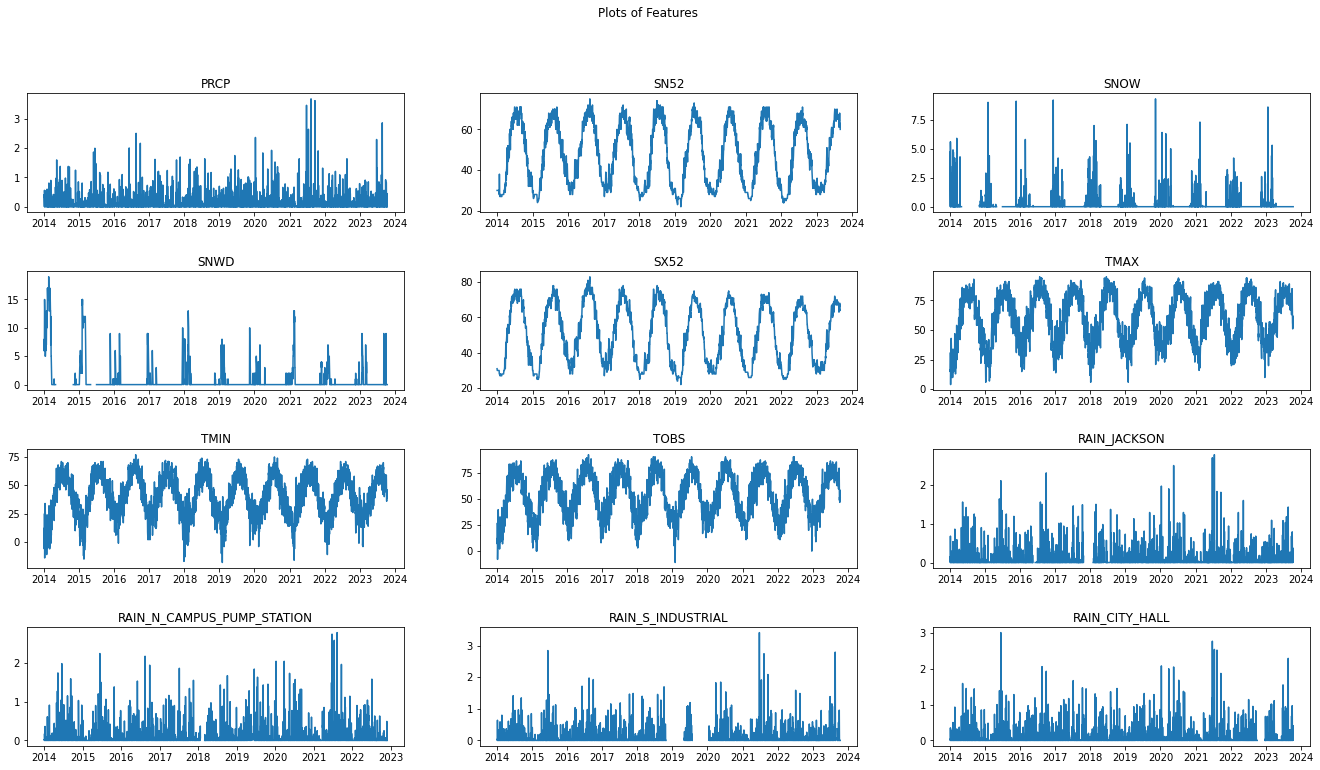

In [32]:
fig, axs = plt.subplots(4,3, figsize=(23, 12))
fig.suptitle("Plots of Features")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()

i = 0
for column in NOAA.columns:
    axs[i].plot(NOAA[column])
    axs[i].set_title(f"{column}")
    i += 1



## Preparing the Response Variable 

Text(0.5, 0.98, 'Delivered Water')

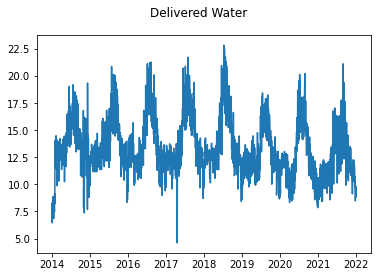

In [33]:
#Get Response
y_true  = pd.read_csv("plant flows 2014-2021 summary.csv")
#create new row and add it
new_row = {'Delivered water': y_true['Delivered water'].mean(), 'Collection Date/Time': '2014/12/06 0:00', 'city': 'New York'}
y_true.loc[len(y_true)] = new_row
#need a date to sort
y_true["DATE"] = pd.to_datetime(y_true['Collection Date/Time']).dt.date
#sort so that dates are in order
y_true = y_true.sort_values(by='DATE', ascending= True)
y_true = y_true.drop_duplicates(subset=['DATE'], keep='last').reset_index(drop = True)
y_true = y_true.drop(["DATE"], axis = 1)
y_true = y_true.set_index("Collection Date/Time")
y_true.index = pd.to_datetime(y_true.index)
#y_true
plt.plot(y_true)
plt.suptitle("Delivered Water")

## Train Test Split

In [34]:
#prediction data
X_Hold_out = NOAA.loc[NOAA.index >= '2022-01-01']


#partition data by timeframe 
X_Test = NOAA.loc[(NOAA.index < '2022-01-01' ) & (NOAA.index >= '2021-01-01')]
y_test = y_true.loc[(y_true.index <= '2022-01-01') & (y_true.index >= '2021-01-01')]
X_Train = NOAA.loc[(NOAA.index < '2021-01-01' )]
y_train = y_true.loc[(y_true.index < '2021-01-01' )]

X_Final_train = NOAA.loc[NOAA.index < '2022-01-01']
y_final_train = y_true


## Feature Engineering 

In [35]:
def  process(df):

    df["WEEKDAY"] = df.index.day_of_week
    df["MONTH"] = df.index.month

    #fill missing temp values
    df["TMIN"].fillna(53.5, inplace = True)
    df["PRCP"].fillna(0, inplace = True)   
    
    #fill missing snow measurements with 0
    df["SNOW"].fillna(0, inplace = True)
    df["SNWD"].fillna(0, inplace = True)

    #add lagged features for temperature and a weekend indicator
    df["TOBS_PREV"] = df["TOBS"].shift(-1)
    df["TOBS_PREV2"] = df["TOBS"].shift(-2)
    df["TOBS_PREV3"] = df["TOBS"].shift(-3)

    df["SNWD_PREV"] = df["SNWD"].shift(-1)
    df["SNWD_PREV2"] = df["SNWD"].shift(-2)
    df["SNWD_PREV3"] = df["SNWD"].shift(-3)

    df['PRCP_PREV'] = df['PRCP'].shift(-1)
    df['PRCP_PREV2'] = df['PRCP'].shift(-1)
    df['PRCP_PREV3'] = df['PRCP'].shift(-1)

    df['SNOW_PREV'] = df['SNOW'].shift(-1)
    df['SNOW_PREV2'] = df['SNOW'].shift(-2)
    df['SNOW_PREV3'] = df['SNOW'].shift(-3)

     #fill resulting na values
    df['PRCP_PREV'].fillna(df['PRCP_PREV'].mean(), inplace = True)
    df['PRCP_PREV2'].fillna(df['PRCP_PREV2'].mean(), inplace = True)
    df['PRCP_PREV3'].fillna(df['PRCP_PREV3'].mean(), inplace = True)
    

    df['SNOW_PREV'].fillna(df['SNOW_PREV'].mean(), inplace = True)
    df['SNOW_PREV2'].fillna(df['SNOW_PREV2'].mean(), inplace = True)
    df['SNOW_PREV3'].fillna(df['SNOW_PREV3'].mean(), inplace = True)

    df["SNWD_PREV"].fillna(df["SNWD_PREV"].mean(), inplace = True)
    df["SNWD_PREV2"].fillna(df["SNWD_PREV2"].mean(), inplace = True)
    df["SNWD_PREV3"].fillna(df["SNWD_PREV3"].mean(), inplace = True)


    df["TOBS_PREV"].fillna(df["TOBS_PREV"].mean(), inplace = True)
    df["TOBS_PREV2"].fillna(df["TOBS_PREV2"].mean(), inplace = True)
    df["TOBS_PREV3"].fillna(df["TOBS_PREV3"].mean(), inplace = True)

    #cyclicly map months to prevent discontinuity
    df["SIN_MONTH"] = np.sin(2*np.pi*df["MONTH"]/max(df["MONTH"]))
    df["COS_MONTH"] = np.cos(2*np.pi*df["MONTH"]/max(df["MONTH"]))
    df["SIN_DAY"] = np.sin(2*np.pi*df["WEEKDAY"]/max(df["WEEKDAY"]))
    df["COS_DAY"] = np.cos(2*np.pi*df["WEEKDAY"]/max(df["WEEKDAY"]))

    #we can't really drop the na's cause we need them for prediction, so we will fill them with -1 and then adda "Missing column" 
    df["MISSING_JACKSON"] = df["RAIN_JACKSON"].isna().astype(int)
    df["RAIN_JACKSON"].fillna(-1, inplace = True)

    df["MISSING_RAIN_N_CAMPUS_PUMP_STATION"] = df["RAIN_N_CAMPUS_PUMP_STATION"].isna().astype(int)
    df["RAIN_N_CAMPUS_PUMP_STATION"].fillna(-1, inplace = True)

    df["MISSING_RAIN_S_INDUSTRIAL"] = df["RAIN_S_INDUSTRIAL"].isna().astype(int)
    df["RAIN_S_INDUSTRIAL"].fillna(-1, inplace = True)

    df["MISSING_RAIN_CITY_HALL"] = df["RAIN_CITY_HALL"].isna().astype(int)
    df["RAIN_CITY_HALL"].fillna(-1, inplace = True)

    #add a weekend indicator
    df["IS_WEEKEND"] = df["WEEKDAY"].isin([5,6])
    df = df.drop(["MONTH"], axis = 1)
    df = df.drop(["WEEKDAY"], axis = 1)

    return df


# Imputing Some missing Values using Manually-Fitted Sin Curves.
# Processing Data

Text(0.5, 1.0, 'Mapped Month')

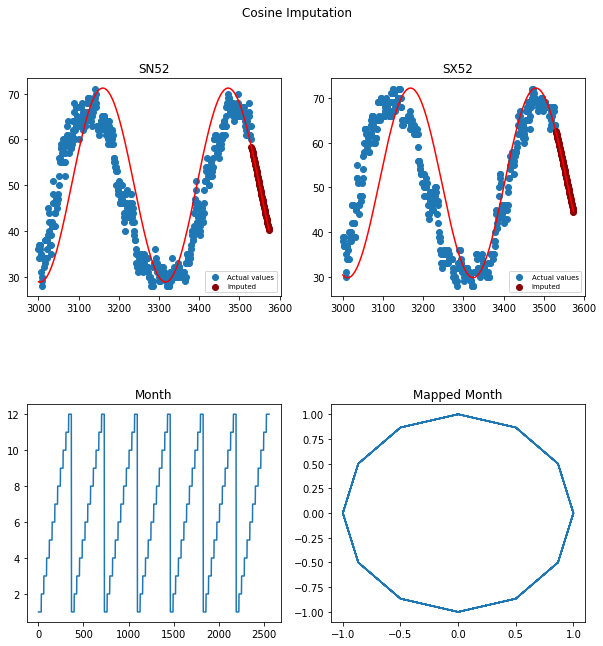

In [36]:
#process training, testing, and hold out data
import warnings
warnings.filterwarnings('ignore')


X_train = process(X_Train)
X_test = process(X_Test)
X_hold_out = process(X_Hold_out)
X_final_train = process(X_Final_train)


#plot the results
missing_SN52= []
for x in range(3530, 3575):
    missing_SN52.append(SN52_predictor(x))
missing_SX52= []
for x in range(3530, 3575):
    missing_SX52.append(SX52_predictor(x))


#generate values that need to be imputed
vals = list(range(3000, 3575))

#Use the fitted sin function to get the values
y_sn52 = []
for x in vals:
    y_i = SN52_predictor(x)
    y_sn52.append(y_i)

y_sx52= []
for x in vals:
    y_i = SX52_predictor(x)
    y_sx52.append(y_i)

#fill them into the hold out set (This is where the values are missing)
sn52 = X_hold_out["SN52"].dropna().values
imputed_sn52 = np.concatenate((sn52, missing_SN52))
X_hold_out["SN52"] = imputed_sn52

sx52 = X_hold_out["SX52"].dropna().values
imputed_sx52 = np.concatenate((sx52, missing_SX52))
X_hold_out["SX52"] = imputed_sx52


#plotting the imputation and month feature mapping
fig, axs = plt.subplots(2,2, figsize=(10, 10))
fig.suptitle("Cosine Imputation")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()


axs[0].scatter(vals, NOAA["SN52"].tail(575),  label = "Actual values")
axs[0].plot(vals, y_sn52, color = "red")
axs[0].set_title("SN52")
axs[0].scatter(list(range(3530, 3575)), missing_SN52, color = "darkred",  label = "imputed")
axs[0].legend(loc ="lower right", fontsize = "7")

axs[1].scatter(vals, NOAA["SX52"].tail(575), label = "Actual values")
axs[1].plot(vals, y_sx52, color = "red")
axs[1].set_title("SX52")
axs[1].scatter(list(range(3530, 3575)), missing_SX52, color = "darkred",  label = "imputed")
axs[1].legend(loc ="lower right", fontsize = "7")


axs[2].plot(list(range(1,2558)), NOAA.head(2557).index.month)
axs[2].set_title("Month")
axs[3].plot(X_train["SIN_MONTH"], X_train["COS_MONTH"])
axs[3].set_title("Mapped Month")

#X_hold_out.head(398)

# Select Best XGB Model


In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

#Making a Pipeline   
pipe = Pipeline( steps = 
    [
      ('scaler', MinMaxScaler()),
      ('polynomial', PolynomialFeatures(degree = 1)),
      ('classifier', GradientBoostingRegressor())
     ]
  )

#Select best model with cross validation (I removed some paramater options once I finished tuning so the notebook runs faster)
gridcv = GridSearchCV(pipe, param_grid = {
                                          'classifier': [GradientBoostingRegressor()],
                                          'classifier__n_estimators': [52],
                                          'classifier__learning_rate': [.08],
                                          'classifier__max_depth': [2],
                                          'polynomial__degree': [2],
                                          'scaler': [MinMaxScaler()]},
                                          cv = 5,
                                          verbose = 3,
                                          return_train_score = True)

  #fit the models
gridcv.fit(X_train, y_train)


error = mean_squared_error(y_test, gridcv.best_estimator_.fit(X_train, y_train).predict(X_test))
print(error)
gridcv.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier=GradientBoostingRegressor(), classifier__learning_rate=0.08, classifier__max_depth=2, classifier__n_estimators=52, polynomial__degree=2, scaler=MinMaxScaler();, score=(train=0.790, test=0.403) total time=   2.3s
[CV 2/5] END classifier=GradientBoostingRegressor(), classifier__learning_rate=0.08, classifier__max_depth=2, classifier__n_estimators=52, polynomial__degree=2, scaler=MinMaxScaler();, score=(train=0.728, test=0.726) total time=   2.4s
[CV 3/5] END classifier=GradientBoostingRegressor(), classifier__learning_rate=0.08, classifier__max_depth=2, classifier__n_estimators=52, polynomial__degree=2, scaler=MinMaxScaler();, score=(train=0.740, test=0.715) total time=   2.2s
[CV 4/5] END classifier=GradientBoostingRegressor(), classifier__learning_rate=0.08, classifier__max_depth=2, classifier__n_estimators=52, polynomial__degree=2, scaler=MinMaxScaler();, score=(train=0.738, test=0.718) total time=   2.

{'classifier': GradientBoostingRegressor(),
 'classifier__learning_rate': 0.08,
 'classifier__max_depth': 2,
 'classifier__n_estimators': 52,
 'polynomial__degree': 2,
 'scaler': MinMaxScaler()}

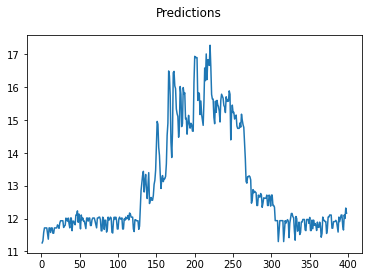

In [38]:
#read output to get correct formatting 
output = pd.read_csv("sample submission.csv")


#refit the best model
best_predictor = gridcv.best_estimator_
best_predictor.fit(X_final_train, y_final_train)

#get predictions
predictions = best_predictor.predict(X_hold_out.head(398))

#create output data frame with formatted datetimes
final_output = pd.DataFrame()
final_output['Collection Date/Time'] = output["Collection Date/Time"]


final_output["Delivered water"] = predictions#-best_constant
final_output = final_output.head(398)
final_output['Collection Date/Time'] = output["Collection Date/Time"]

#Re-order the columns
names = ["Collection Date/Time","Delivered water"]
final_output=final_output.reindex(columns=names)

#Export the predictions
final_output.to_csv('output.csv', index=False)
plt.suptitle("Predictions")

#plot the predictions
plt.plot(list(range(1,399)),predictions )
